# Classificacao com SVM

# 0 Importação

In [1]:
import os
import glob
import time
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

In [2]:
SEED_VALUE = 42

# Fix seed to make training deterministic.
np.random.seed(SEED_VALUE)

In [3]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    classification_report, confusion_matrix
)
from sklearn.decomposition import PCA

# 1 Configuração

In [4]:
image_size = (64, 64)
dataset_path = "./datasets/Plastic_Classification"
os.makedirs("models/04_svm", exist_ok=True)

# 2 Função de Carregamento

In [5]:
def carregar_imagens(pasta, image_size=(64, 64)):
    X, y = [], []
    for classe in sorted(os.listdir(pasta)):
        caminho_classe = os.path.join(pasta, classe)
        if not os.path.isdir(caminho_classe):
            continue
        for arquivo in glob.glob(os.path.join(caminho_classe, "*.jpg")):
            img = cv2.imread(arquivo, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            X.append(img.flatten() / 255.0)
            y.append(classe)
    return np.array(X), np.array(y)

# 3 Pré-processamento

In [6]:
X_train, y_train = carregar_imagens(os.path.join(dataset_path, "train"))
X_val, y_val = carregar_imagens(os.path.join(dataset_path, "validation"))
X_test, y_test = carregar_imagens(os.path.join(dataset_path, "test"))

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

In [7]:
# -------------------------------
# PCA PARA REDUÇÃO DE DIMENSIONALIDADE
# -------------------------------
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

joblib.dump(pca, "models/04_svm/pca_transformer_svm.joblib")

['models/04_svm/pca_transformer_svm.joblib']

# 4 Treinamento do modelo 

In [8]:
model = SVC(
    kernel="rbf",
    probability=True,
    C=1.0,
    gamma="scale",
    verbose=True,
    random_state=42
)

start_train = time.time()
model.fit(X_train_pca, y_train_enc)
train_time = time.time() - start_train

[LibSVM]

# 5 Avaliação

In [9]:
start_pred = time.time()
y_pred = model.predict(X_test_pca)
inference_time = (time.time() - start_pred) / len(X_test)

y_proba = model.predict_proba(X_test_pca)

acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average="weighted")
loss = log_loss(y_test_enc, y_proba)

print(f"\n🧰 Tempo de treino: {train_time:.2f}s")
print(f"⚡ Tempo de inferência (por imagem): {inference_time*1000:.2f} ms")
print(f"✅ Acurácia: {acc:.4f}")
print(f"🎯 F1-score ponderado: {f1:.4f}")
print(f"📉 Log Loss: {loss:.4f}\n")
print("📋 Classification Report:\n")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))


🧰 Tempo de treino: 4.15s
⚡ Tempo de inferência (por imagem): 0.97 ms
✅ Acurácia: 0.3349
🎯 F1-score ponderado: 0.2872
📉 Log Loss: 1.6889

📋 Classification Report:

              precision    recall  f1-score   support

        HDPE       0.00      0.00      0.00        30
        LDPA       0.55      0.57      0.56        30
       Other       0.09      0.03      0.05        30
         PET       0.56      0.17      0.26        29
          PP       0.48      0.93      0.64        30
          PS       0.26      0.47      0.34        30
         PVC       0.17      0.17      0.17        30

    accuracy                           0.33       209
   macro avg       0.30      0.33      0.29       209
weighted avg       0.30      0.33      0.29       209



# 6 Matriz de confusão

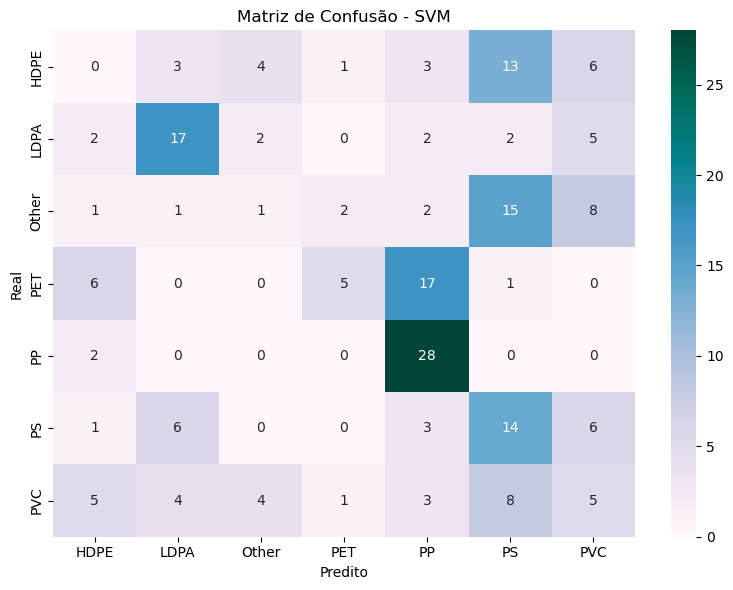

In [10]:
cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBuGn', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusão - SVM")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# 7 Previsão 

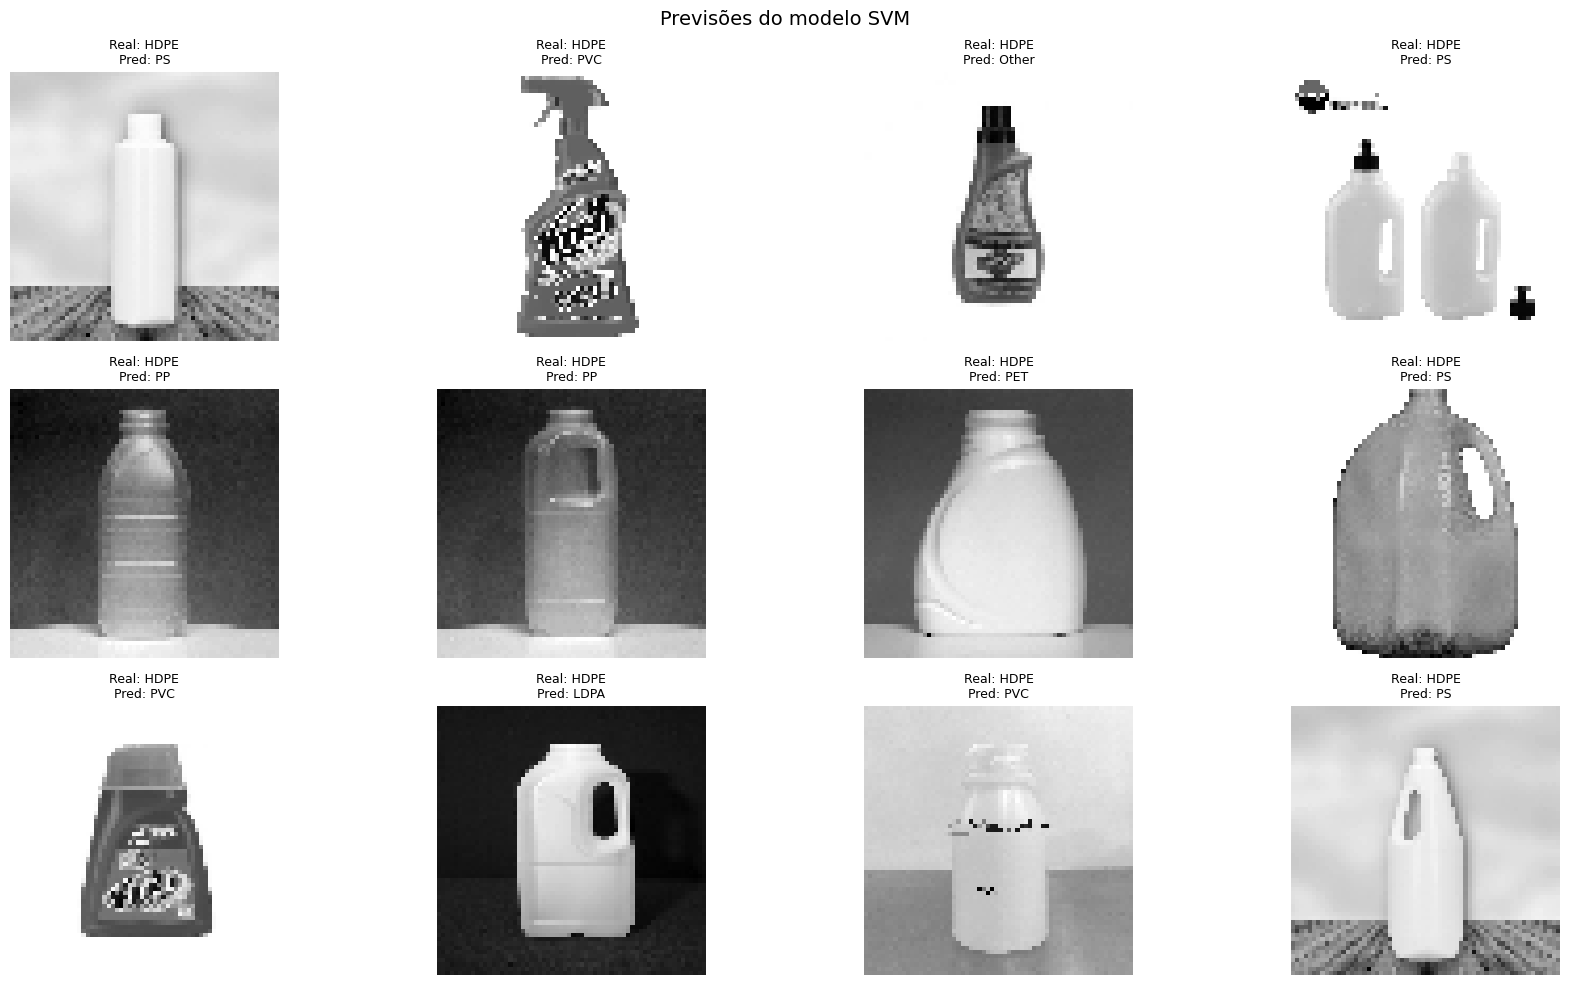

In [11]:
X_test_imgs = X_test.reshape((-1, 64, 64)) * 255.0
real_labels = le.inverse_transform(y_test_enc)
pred_labels = le.inverse_transform(y_pred)

plt.figure(figsize=(18, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test_imgs[i], cmap="gray")
    plt.axis("off")
    plt.title(f"Real: {real_labels[i]}\nPred: {pred_labels[i]}", fontsize=9)
plt.suptitle("Previsões do modelo SVM", fontsize=14)
plt.tight_layout()
plt.show()

# 8 Salvar o modelo e as metricas

In [12]:
joblib.dump(model, "models/04_svm/svm_model.joblib")
joblib.dump(le, "models/04_svm/label_encoder_svm.joblib")

with open("models/04_svm/svm_metrics.json", "w") as f:
    json.dump({
        "model": "SVM",
        "accuracy": acc,
        "f1_score_weighted": f1,
        "log_loss": loss,
        "train_time_sec": train_time,
        "inference_time_ms": inference_time * 1000
    }, f, indent=4)
joblib.dump((X_test, y_test), "models/test_data_for_comparisons.joblib")
print("✅ Dados de teste salvos com sucesso.")

✅ Dados de teste salvos com sucesso.
